# Step 2.1) Feature engineering: calls

Even though number of calls is not a time series on it's own, it could reflext certain factors, that are a time series, not only the weather, but also other human factors. Previously we named these features $\tilde X$.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
time_series_hourly = pd.read_csv('files/ts_analysis_data.csv',sep=';',decimal=',')
time_series_hourly = time_series_hourly.drop_duplicates(subset=['DT_ISO']) #make sure no duplicates are present
time_series_hourly = time_series_hourly.reset_index(drop=True)
calls_time_series_hourly=time_series_hourly[["DT_ISO","NUMB_CALLS"]]

In [3]:
calls_time_series_hourly.set_index("DT_ISO", inplace=True)
calls_time_series_hourly.head()

,NUMB_CALLS
DT_ISO,
2015-11-01 00:00:00.000000,20
2015-11-01 01:00:00.000000,43
2015-11-01 02:00:00.000000,13
2015-11-01 03:00:00.000000,12
2015-11-01 04:00:00.000000,9


### Calls distribution

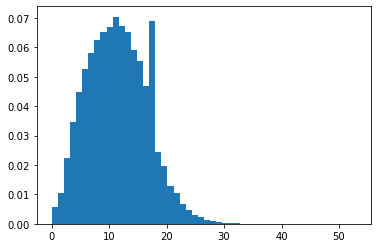

In [4]:
plt.hist(calls_time_series_hourly.NUMB_CALLS, density=True, bins=50)
plt.show()

Looks like the number of calls per hour is normally distributed.

In [5]:
def plot_one_graph(datafr):
    fig, ax = plt.subplots(figsize=(30, 10))
    ax.plot_date(x=datafr.index, y=datafr.NUMB_CALLS, fmt="r-")
    plt.setp(ax.get_xticklabels(), rotation=45,)
    plt.ylabel("number of calls")
    plt.grid(True)
    plt.show()
    return

### Hourly paterns

In [6]:
calls_time_series_one_day= calls_time_series_hourly[:'2020-10-01']

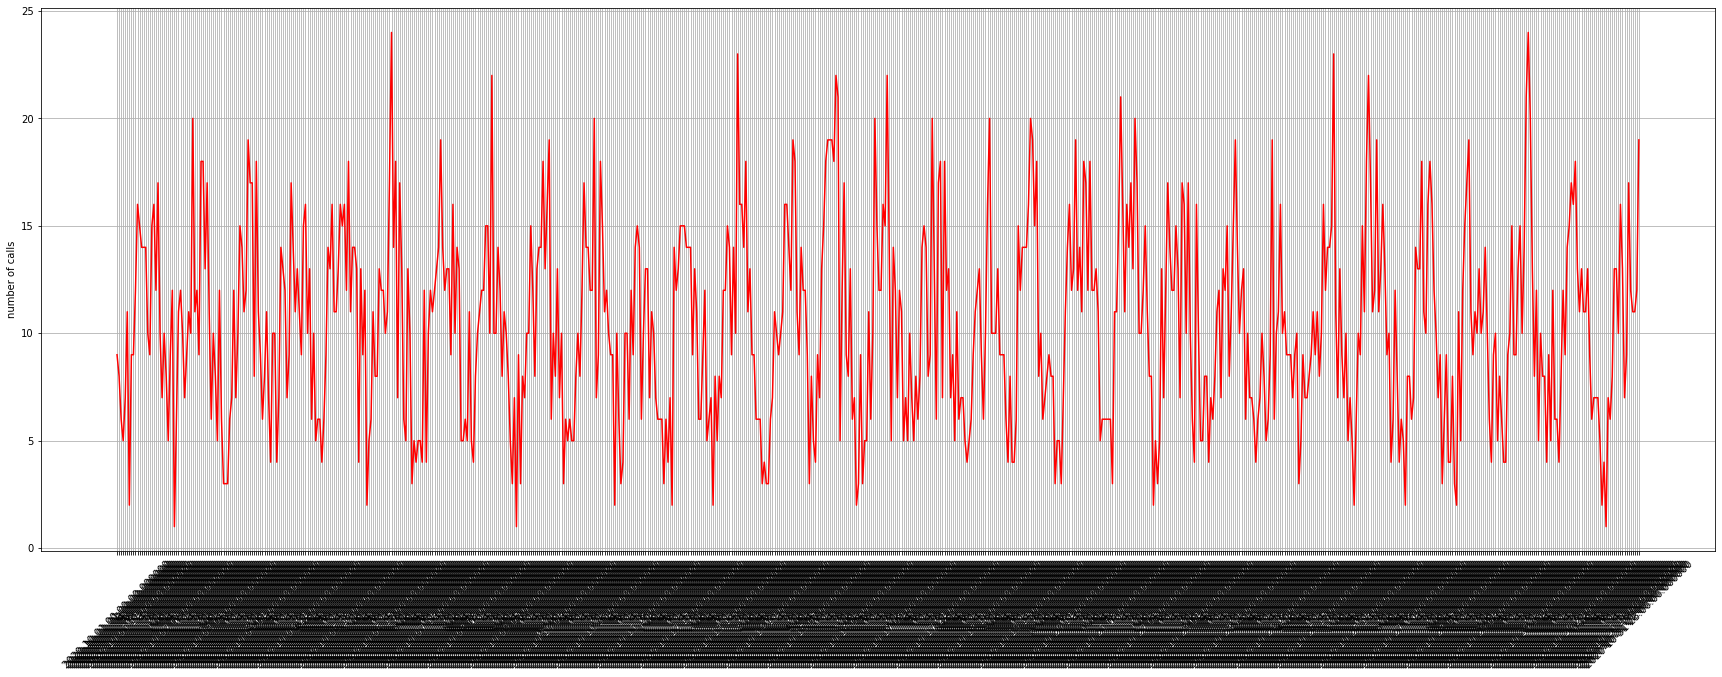

In [7]:
# plot hourly calls during one month
calls_time_series_last_month = calls_time_series_hourly[calls_time_series_hourly.index>'2020-10-01']
plot_one_graph(calls_time_series_last_month)

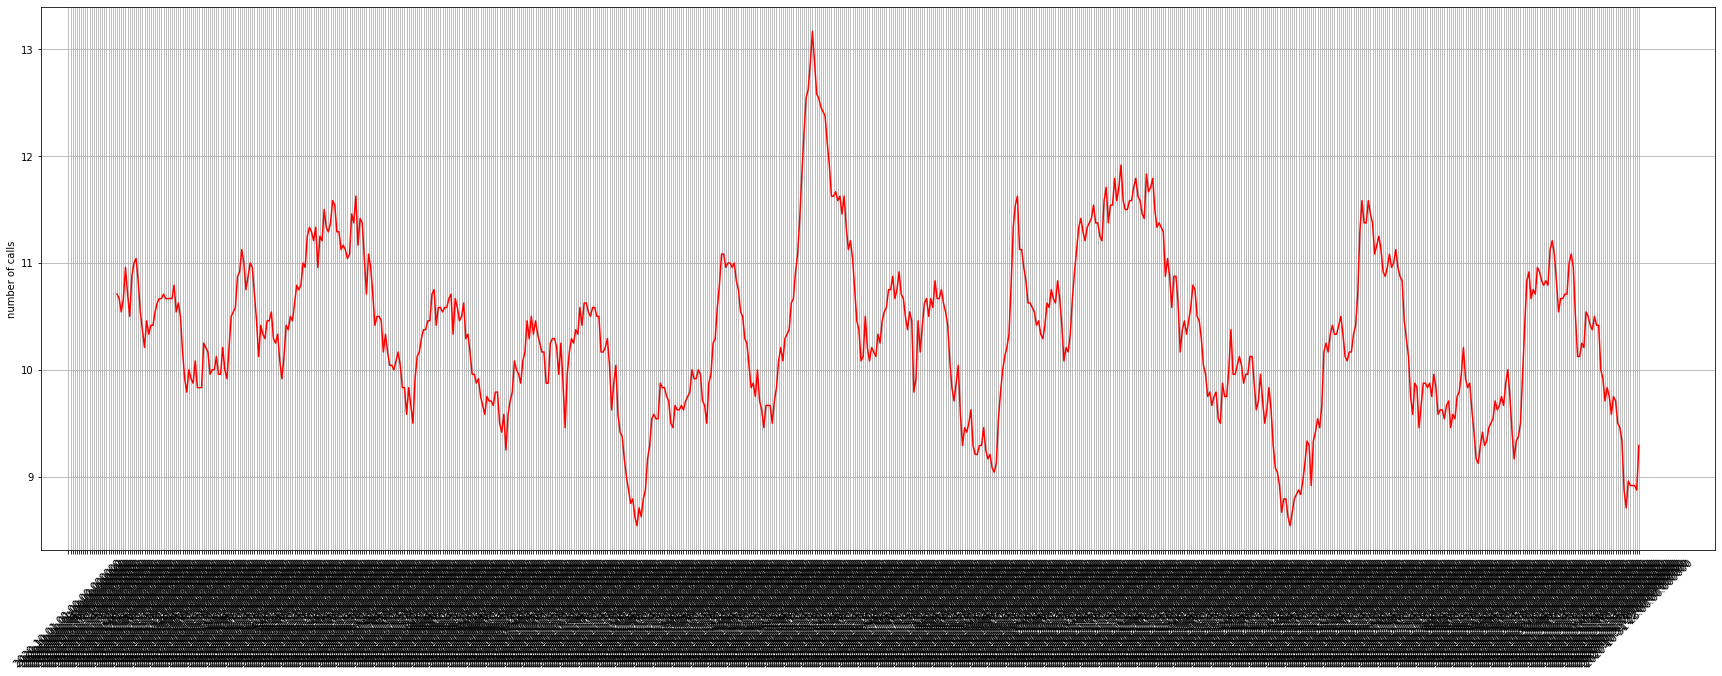

In [8]:
plot_one_graph(calls_time_series_last_month.rolling(24).mean()) # moving average over 24 hours, one day

Looking at the graphs, it is hard to understand any patterns yet. <br>
In order to understand how number of calls are connected with the past data, i.e. autocorrelated we plot the ACF (autocorrelation function).

In [9]:
from statsmodels.graphics.tsaplots import plot_acf

<Figure size 1440x1440 with 0 Axes>

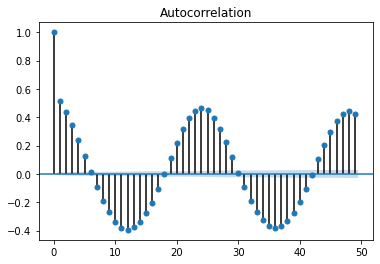

In [10]:
with plt.rc_context():
    plt.figure("figure",figsize=(20,20))
    plot_acf(calls_time_series_hourly['NUMB_CALLS'],lags=49)
    plt.show()

On the X axis we have lags, and Y axis the $R^2$. E.g. for lag = 1, we have correlation ~0.5, which means that the number of calls now are somewhat connected (0.5) with the number of calls one hour ago. 

We conclude, in order to predict the number of calls at one time is correlated with the number of calls **1 hour ago and also 1 day (24 hours) ago**. This could be also explained by the fact that calls depend on weather and weather now depends very much on the weather one hour ago. 

###  Daily patterns.

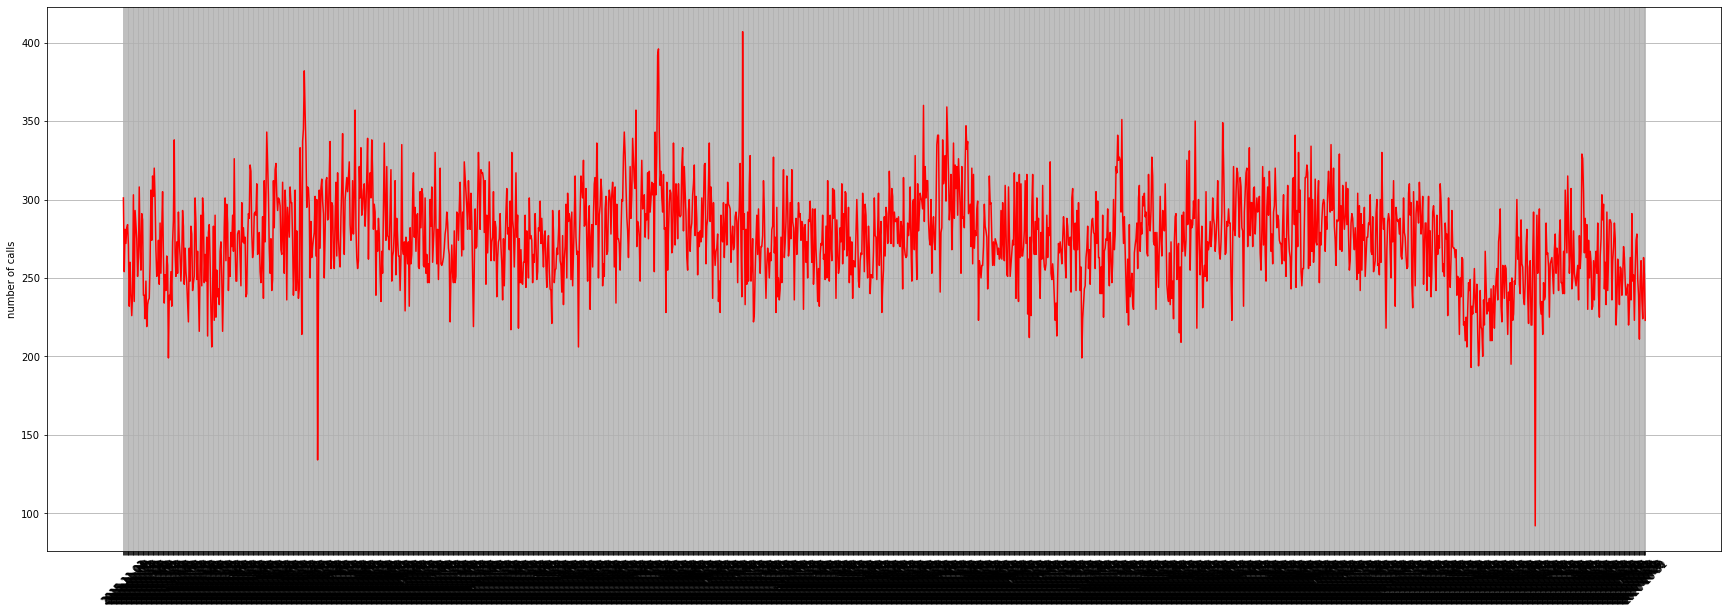

In [11]:
# in the previous query we also aggregated the call data per day for years 11.2015-11.2019  
calls_time_series_daily = pd.read_csv('files/calls_per_day.csv',sep=';',decimal=',')
calls_time_series_daily.set_index("DATE_DAY", inplace=True)
plot_one_graph(calls_time_series_daily)

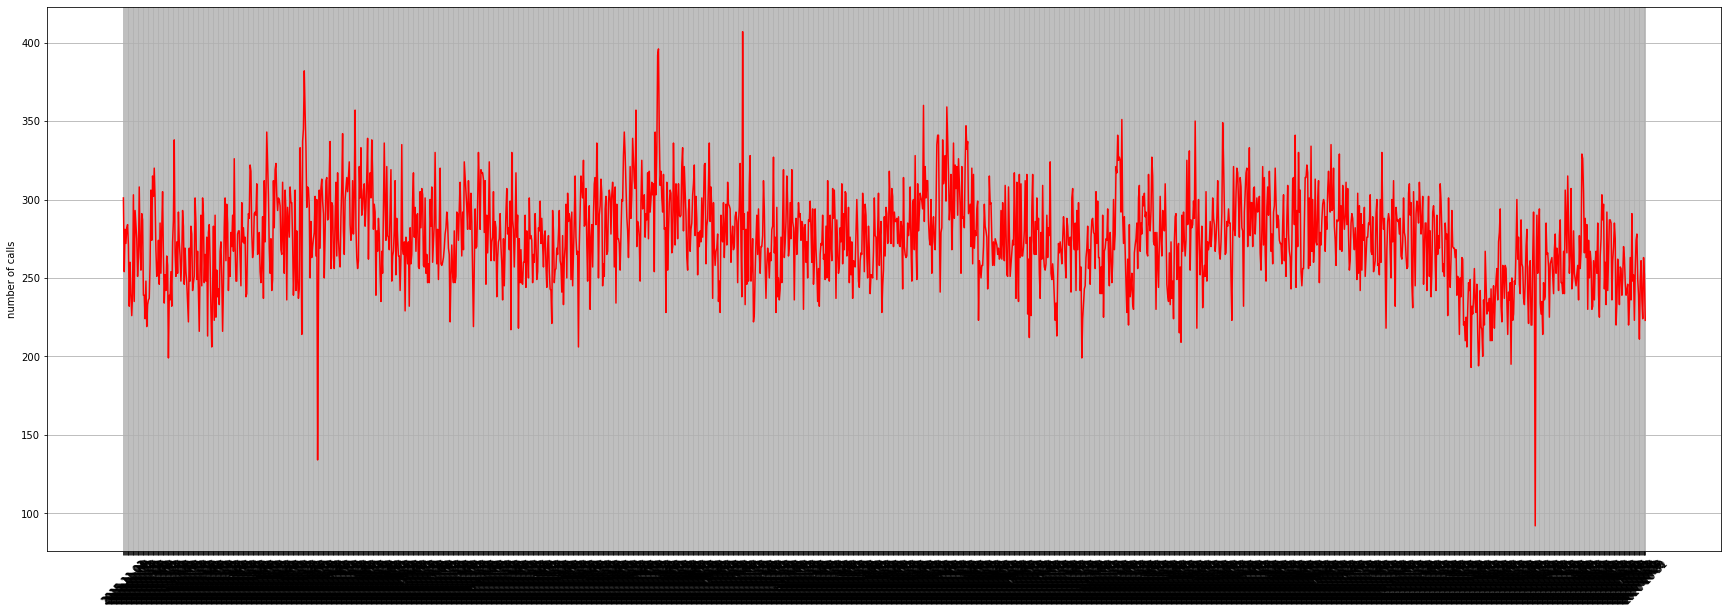

In [12]:
plot_one_graph(calls_time_series_daily)

We see that there is **no clear trend** in the data. The data is slightly **cyclic**. <br>

<Figure size 1440x1440 with 0 Axes>

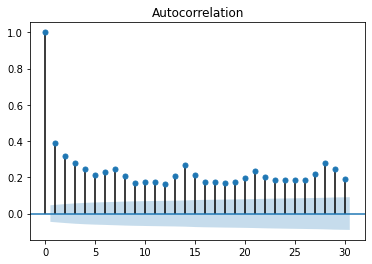

In [13]:
with plt.rc_context():
    plt.figure("figure",figsize=(20,20))
    plot_acf(calls_time_series_daily['NUMB_CALLS'],lags=30)

We see that the calls are connected to the number of calls on previous days. <br>
We can see that every 7th lag we get a slightly **higher correlation**, which is related to the **weekdays**. Though it is correlated not very strongly, we will also consider adding this information. <br>
Thus we will consider  **the hour and the weekday** as new features for better prediction.

<Figure size 1440x1440 with 0 Axes>

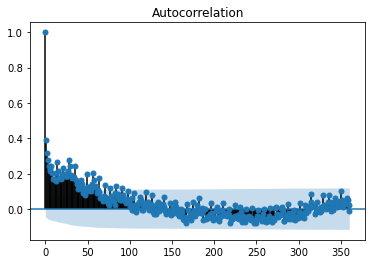

In [14]:
with plt.rc_context():
    plt.figure("figure",figsize=(20,20))
    plot_acf(calls_time_series_daily['NUMB_CALLS'],lags=360)

By looking at the lags extending to the whole year, we see that there is no correlation of current day with days, from more than 2 months ago. (at 60 we see that the ACF is within the blue area). Let us see closer the first 60 lags:

<Figure size 1440x1440 with 0 Axes>

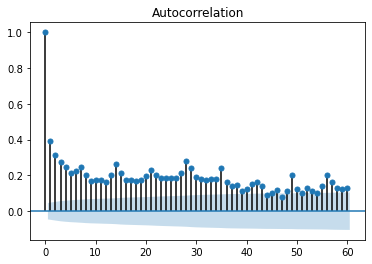

In [15]:
with plt.rc_context():
    plt.figure("figure",figsize=(20,20))
    plot_acf(calls_time_series_daily['NUMB_CALLS'],lags=60)

By looking at the graph,we see increases after 4 weeks. This way we can consider also  **the month** to be one of new attributes too.

It could be easier to see more patterns if we smooth the graph out by ploting the rolling average (moving average): 

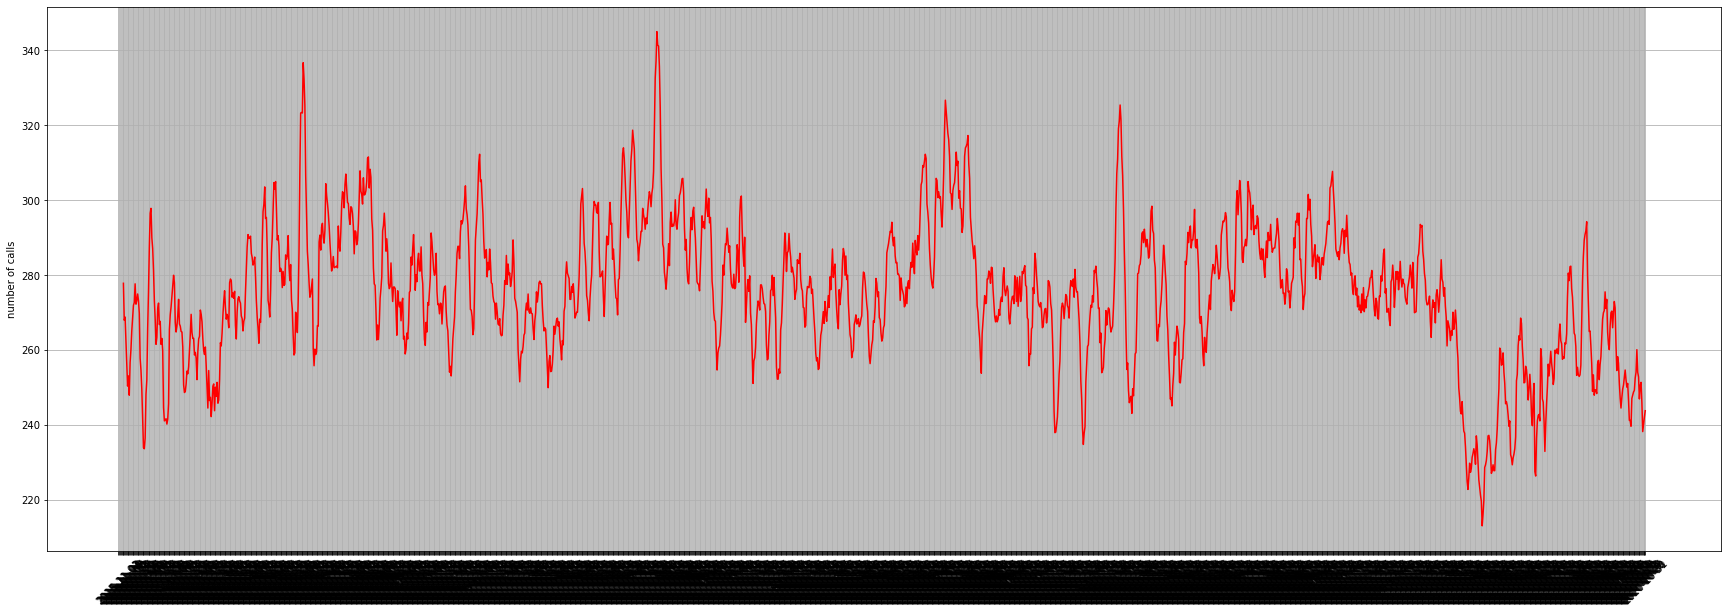

In [16]:
calls_time_series_daily_roll_avg = calls_time_series_daily.rolling(7).mean() #7-day moving agerage
plot_one_graph(calls_time_series_daily_roll_avg)

In [17]:
# let's see the time series during 2 years
year_2016=calls_time_series_daily[(calls_time_series_daily.index<'2017-01-01')&(calls_time_series_daily.index>='2016-01-01')]
year_2017=calls_time_series_daily[(calls_time_series_daily.index>='2017-01-01')&(calls_time_series_daily.index<'2018-01-01')]
year_2018=calls_time_series_daily[(calls_time_series_daily.index>='2018-01-01')&(calls_time_series_daily.index<'2019-01-01')]
# let's check if they contain all the days of the year
print(len(year_2016) == 366) # February in 2016 has 29 days
print(len(year_2017)==365)
print(len(year_2017)==365) 

True
True
True


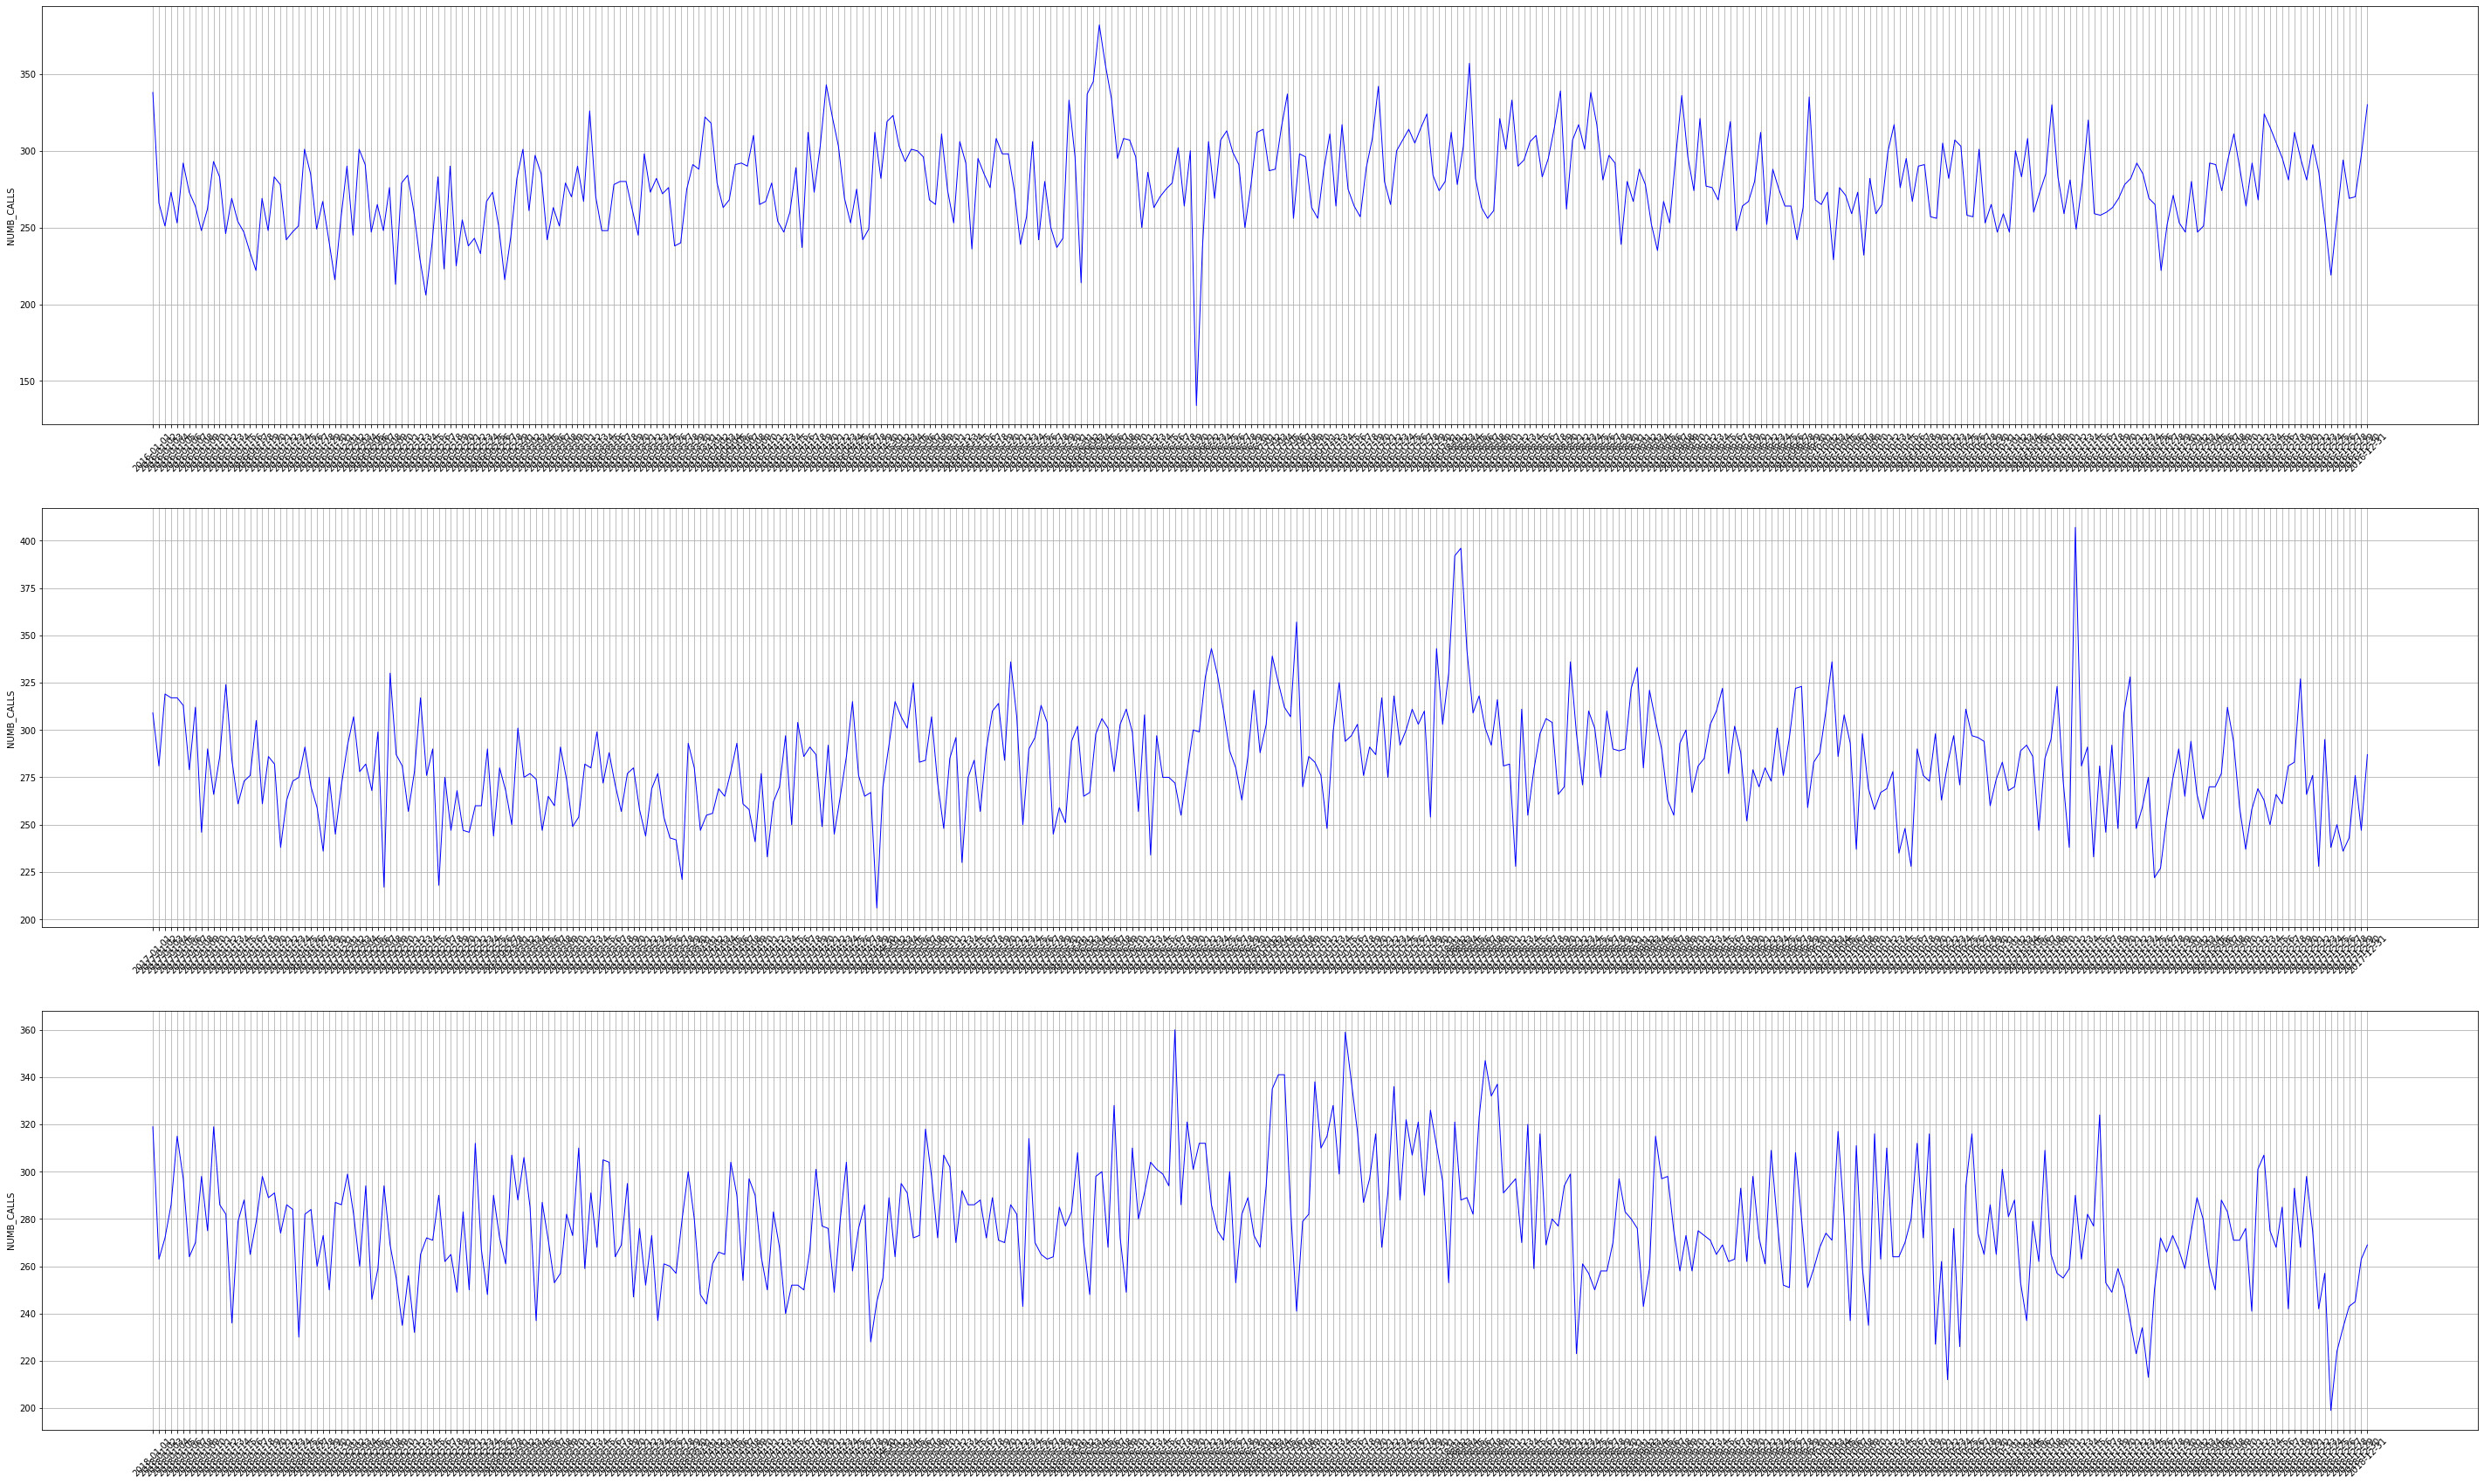

In [18]:
plt.figure(figsize=(50, 30))

ax1 = plt.subplot(3, 1, 1)
plt.setp(ax1.get_xticklabels(), rotation=45)
plt.grid(True)
ax1.set_ylabel('NUMB_CALLS')
ax1.plot(year_2016.index, year_2016.NUMB_CALLS, color='b', linewidth=1)

ax2 = plt.subplot(3, 1, 2)
plt.setp(ax2.get_xticklabels(), rotation=45)
plt.grid(True)
ax2.set_ylabel('NUMB_CALLS')
ax2.plot(year_2017.index, year_2017.NUMB_CALLS, color='b', linewidth=1)

ax3 = plt.subplot(3, 1, 3)
plt.setp(ax3.get_xticklabels(), rotation=45)
plt.grid(True)
ax3.set_ylabel('NUMB_CALLS')
ax3.plot(year_2018.index, year_2018.NUMB_CALLS, color='b', linewidth=1)

From these graphs, we can see that during all the years the number of calls increases in the middle of the year. It is logical, as in summer the heat could cause fire easier. Even though the information about the season is already captured in the weather changes, the rise of fire calls in the summer could be also explained with people's behaviour during summer time. People go out more, make bonfires, etc. This way we will include the **season as an attribute**. In the following graphs it's more visible: 

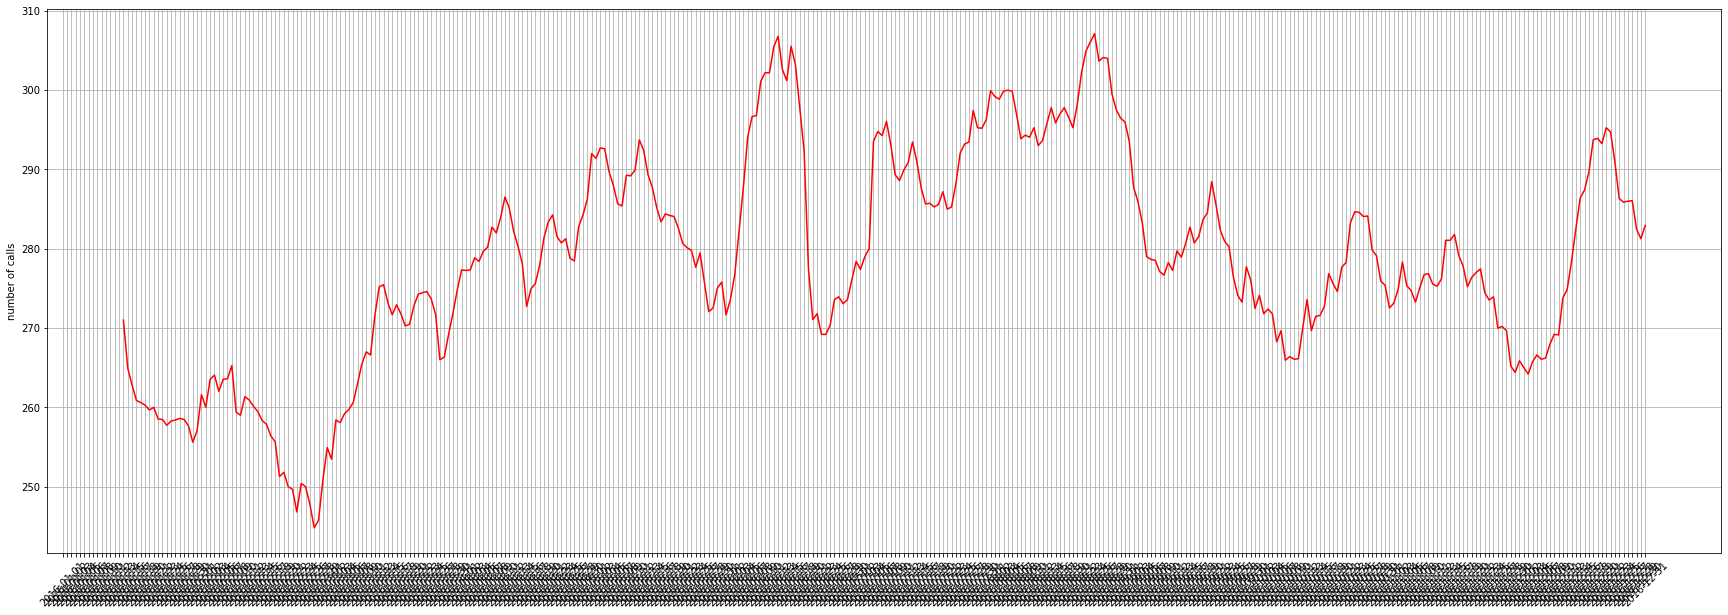

In [19]:
plot_one_graph(year_2016.rolling(15).mean())

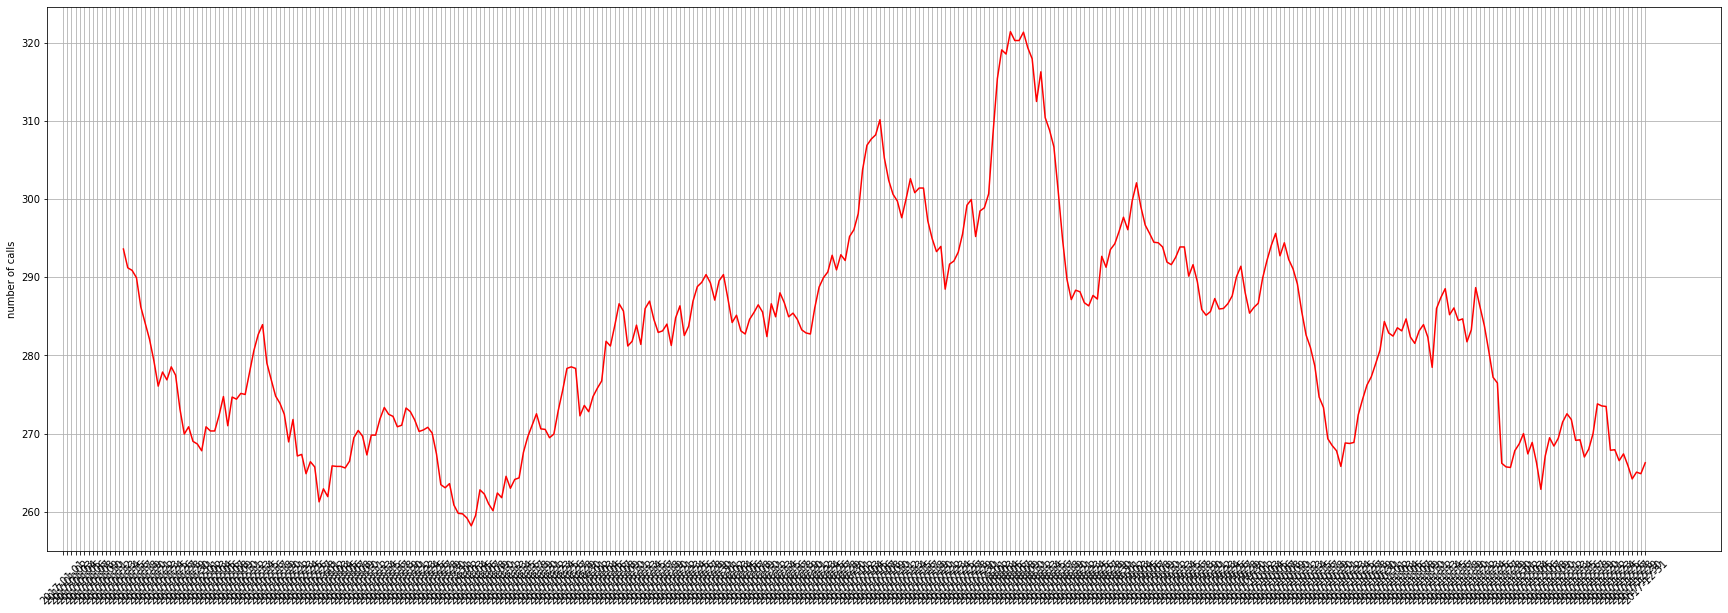

In [20]:
plot_one_graph(year_2017.rolling(15).mean())

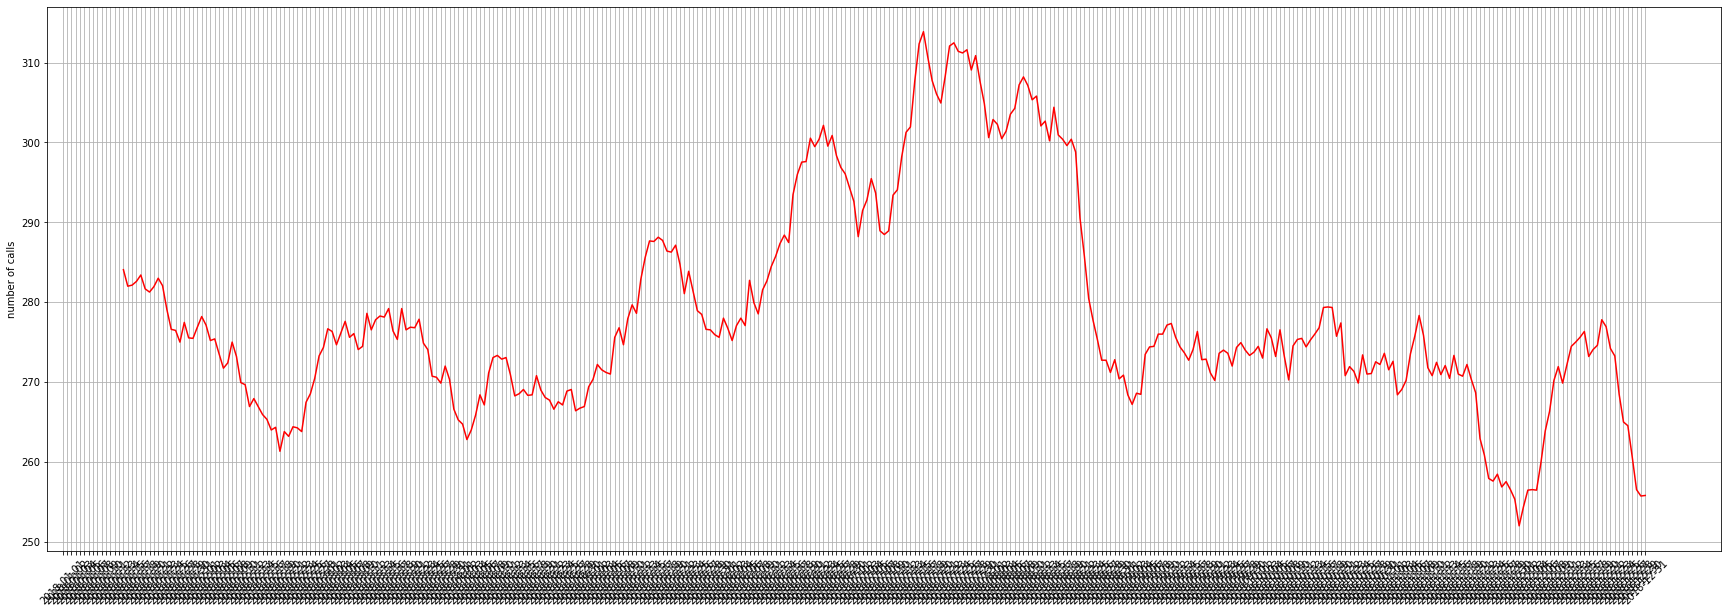

In [21]:
plot_one_graph(year_2018.rolling(15).mean())

After our little investigation, we will add the following features to our dataset:
* hour of the day 
* day of the week  
* month of the year 
* season
* (other attributes, e.g. whether a day is a holiday, .. etc could be considered too, but for simplicity we will stop here )<br>

